# Пример использования библиотеки Synthetic Control

В этом примере мы покажем, как использовать библиотеку для анализа эффекта запрета на курение в Калифорнии в 1989 году.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from synthetic_control import ClassicSyntheticControl, plot_synthetic_control

In [2]:
from synthetic_control import SyntheticDIDModel, plot_synthetic_control

## Загрузка и подготовка данных

Загрузим данные о потреблении сигарет на душу населения по штатам.

In [3]:
df = pd.read_csv('../data/smoking.csv')

df.head()

melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["is_California"] = melt_df["state"] == "California"
melt_df

df_long = (
    df
    .reset_index()
    .rename(columns={'index': 'time'})     
    .melt(id_vars='time', var_name='state', value_name='cigarettes')
)

df_long['unit'] = df_long['state'].astype('category').cat.codes

treated_unit_code = df_long[df_long['state'] == 'California']['unit'].iloc[0]
df_long['treated'] = df_long['unit'] == treated_unit_code

df_long['year'] = df_long['time'] + 1970

df_long = df_long[(df_long['year'] >= 1970) & (df_long['year'] <= 2000)]

df_long = df_long.reset_index(drop=True).drop(columns=['time'])

T0 = 1989
df_long['after_treatment'] = df_long['year'] >= T0

In [4]:
df_post = df_long[df_long['after_treatment']]
print("\nПроверка данных в пост-интервенционном периоде:")
print(f"Количество наблюдений для Калифорнии: {df_post[df_post['treated']].shape[0]}")
print(f"Количество наблюдений для контрольных штатов: {df_post[~df_post['treated']].shape[0]}")

print("\nДанные для Калифорнии:")
print(df_long[df_long['treated']].sort_values('year'))

print("\nДанные для контрольных штатов:")
print(df_long[~df_long['treated']].sort_values('year').head())


Проверка данных в пост-интервенционном периоде:
Количество наблюдений для Калифорнии: 12
Количество наблюдений для контрольных штатов: 456

Данные для Калифорнии:
           state  cigarettes  unit  treated  year  after_treatment
1178  California  123.000000     2     True  1970            False
1179  California  121.000000     2     True  1971            False
1180  California  123.500000     2     True  1972            False
1181  California  124.400002     2     True  1973            False
1182  California  126.699997     2     True  1974            False
1183  California  127.099998     2     True  1975            False
1184  California  128.000000     2     True  1976            False
1185  California  126.400002     2     True  1977            False
1186  California  126.099998     2     True  1978            False
1187  California  121.900002     2     True  1979            False
1188  California  120.199997     2     True  1980            False
1189  California  118.599998    

## Создание и обучение модели

In [5]:
sc = ClassicSyntheticControl(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    shopno='state',
    treated='treated',
    after_treatment='after_treatment',
    seed=0
)

sc.fit()

In [6]:
sdid_model = SyntheticDIDModel(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    shopno='state',
    treated='treated',
    after_treatment='after_treatment',
    seed=0
)

sdid_model.fit()

## Оценка эффекта

In [7]:
effect = sc.estimate_effect()
print(f"Оценка эффекта: {effect['att']:.2f} сигарет на душу населения")

bootstrap_results = sc.bootstrap_effect()
print(f"Стандартная ошибка: {bootstrap_results['se']:.2f}")
print(f"95% доверительный интервал: [{bootstrap_results['ci_lower']:.2f}, {bootstrap_results['ci_upper']:.2f}]")

Оценка эффекта: -19.51 сигарет на душу населения
Стандартная ошибка: 10.67
95% доверительный интервал: [-40.43, 1.41]


In [8]:
effect = sdid_model.estimate_effect()
print(f"Оценка эффекта воздействия (ATT): {effect['att']:.4f}")

bootstrap_results = sdid_model.bootstrap_effect()
print(f"Стандартная ошибка: {bootstrap_results['se']:.4f}")
print(f"95% доверительный интервал: [{bootstrap_results['ci_lower']:.4f}, {bootstrap_results['ci_upper']:.4f}]")

Оценка эффекта воздействия (ATT): -15.6051
Стандартная ошибка: 8.8115
95% доверительный интервал: [-32.8753, 1.6651]


## Визуализация результатов

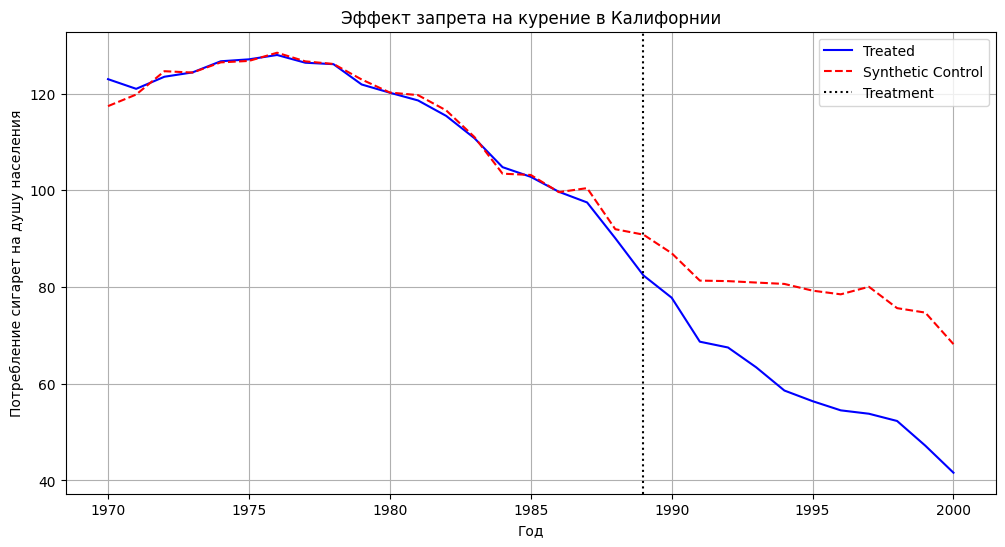

In [9]:
predictions = sc.predict()

fig = plot_synthetic_control(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    shopno='state',
    treated='treated',
    after_treatment='after_treatment',
    predictions=predictions,
    treatment_date=1989,
    title='Эффект запрета на курение в Калифорнии',
    xlabel='Год',
    ylabel='Потребление сигарет на душу населения'
)

plt.show()

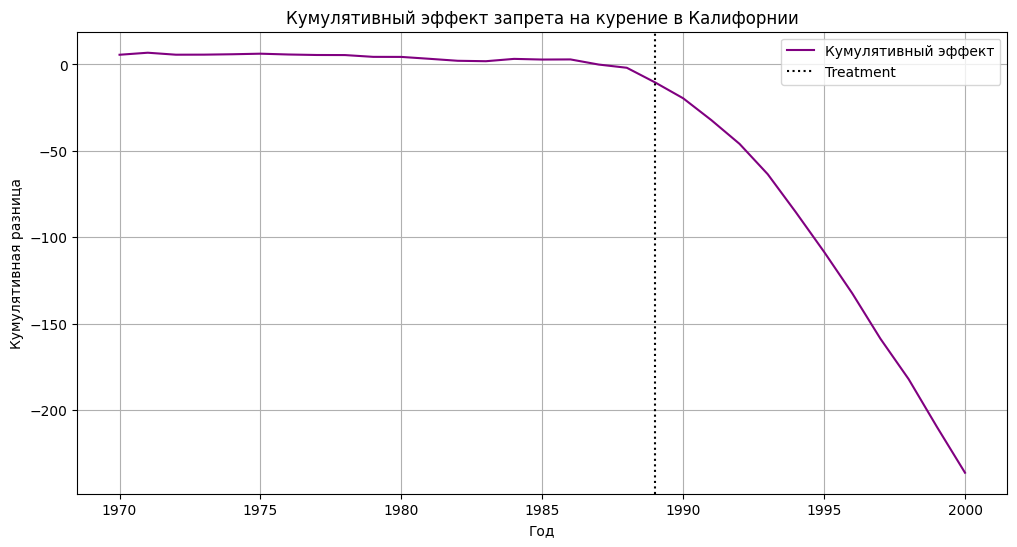

In [10]:
from synthetic_control.visualization import plot_cumulative_effect

fig = plot_cumulative_effect(
    data=df_long,
    metric='cigarettes',
    period_index='year',
    treated='treated',
    predictions=predictions,
    treatment_date=1989,
    title='Кумулятивный эффект запрета на курение в Калифорнии',
    xlabel='Год',
    ylabel='Кумулятивная разница'
)
plt.show()

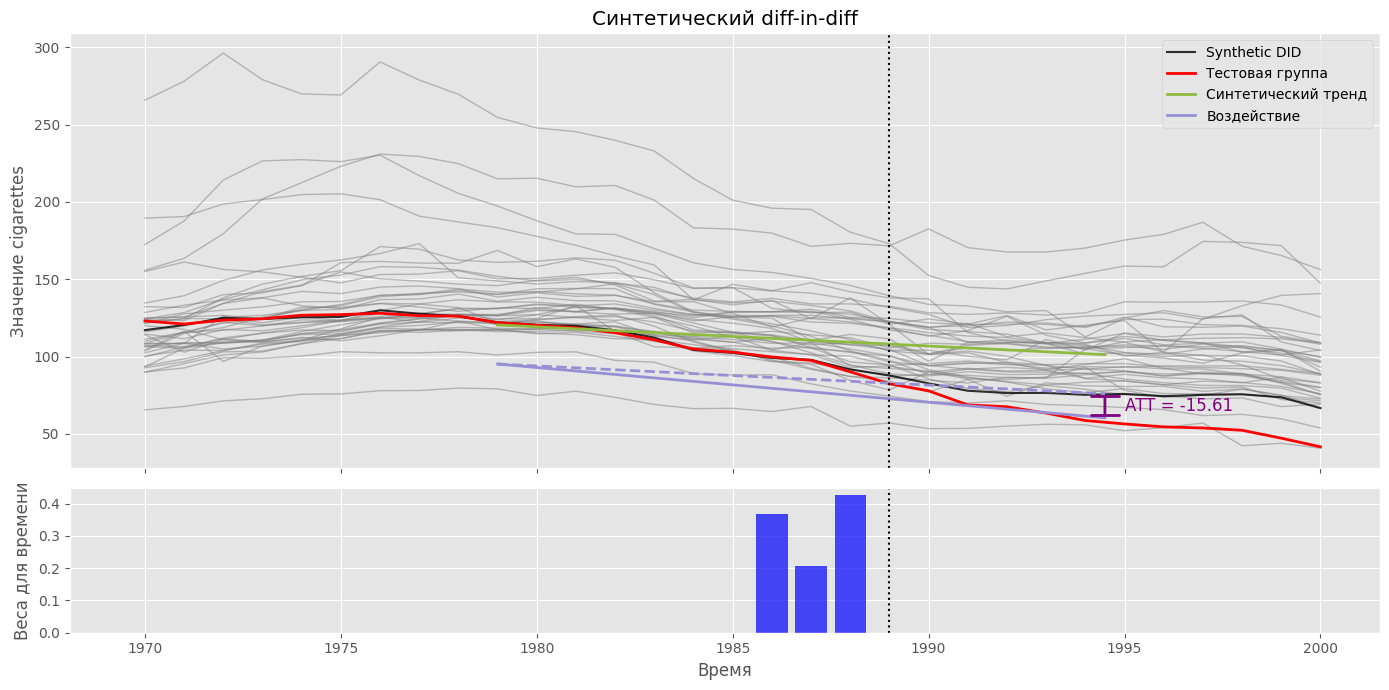

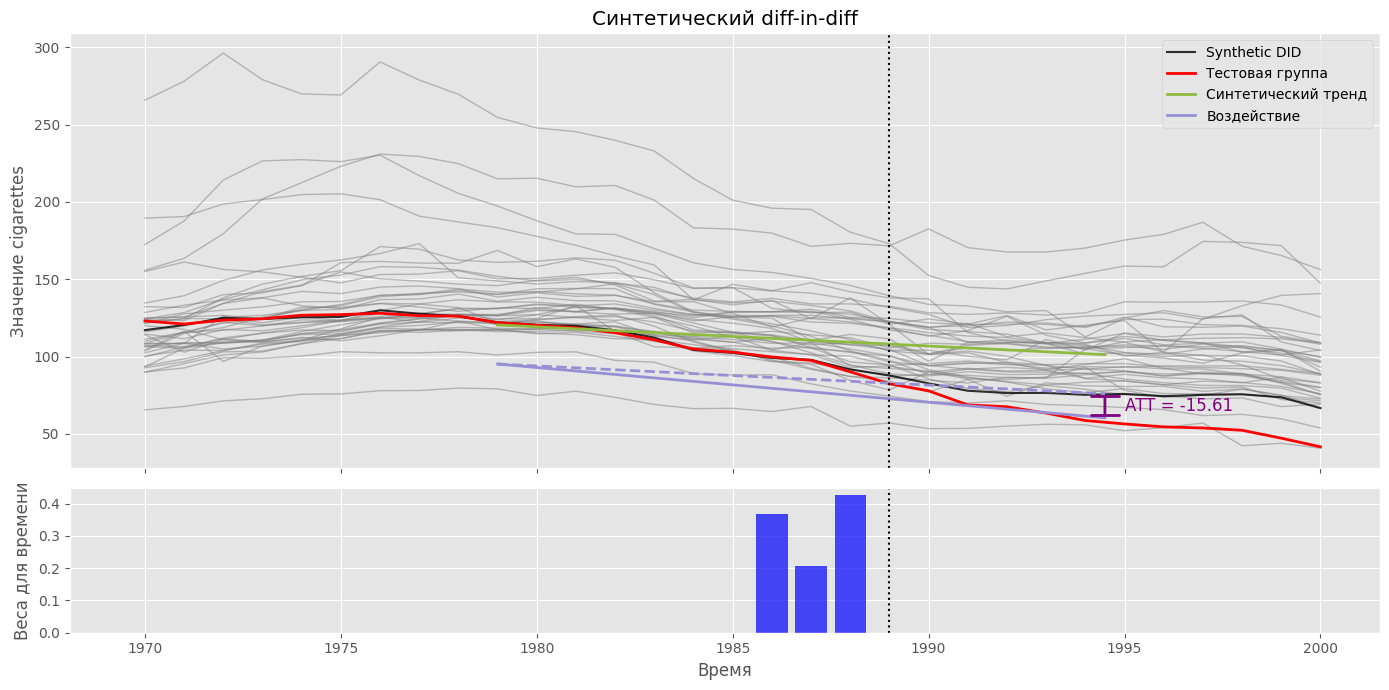

In [11]:
from synthetic_control import SyntheticDIDModel, plot_synthetic_diff_in_diff

plot_synthetic_diff_in_diff(
    model=sdid_model,
    T0=1989,
    figsize=(14, 7)
)

## Визуализация весов контрольных единиц

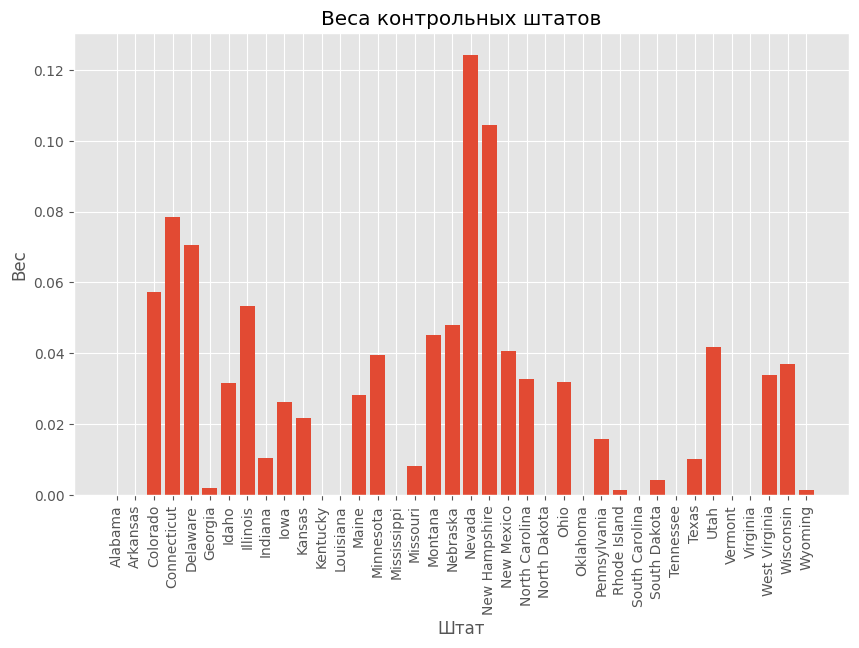

In [12]:
from synthetic_control import plot_weights

fig = plot_weights(
    effect['weights'],
    title='Веса контрольных штатов',
    xlabel='Штат',
    ylabel='Вес'
)
plt.xticks(rotation=90)
plt.show()

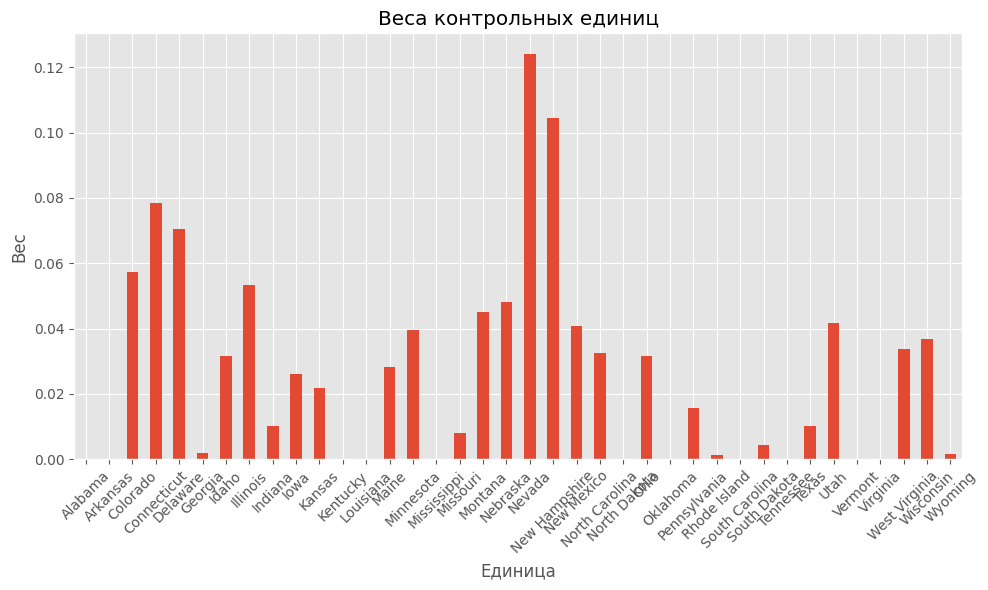

In [13]:
# Визуализация весов единиц
unit_weights = sdid_model.unit_weights_

plt.figure(figsize=(10, 6))
unit_weights.plot(kind='bar')
plt.title('Веса контрольных единиц')
plt.xlabel('Единица')
plt.ylabel('Вес')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

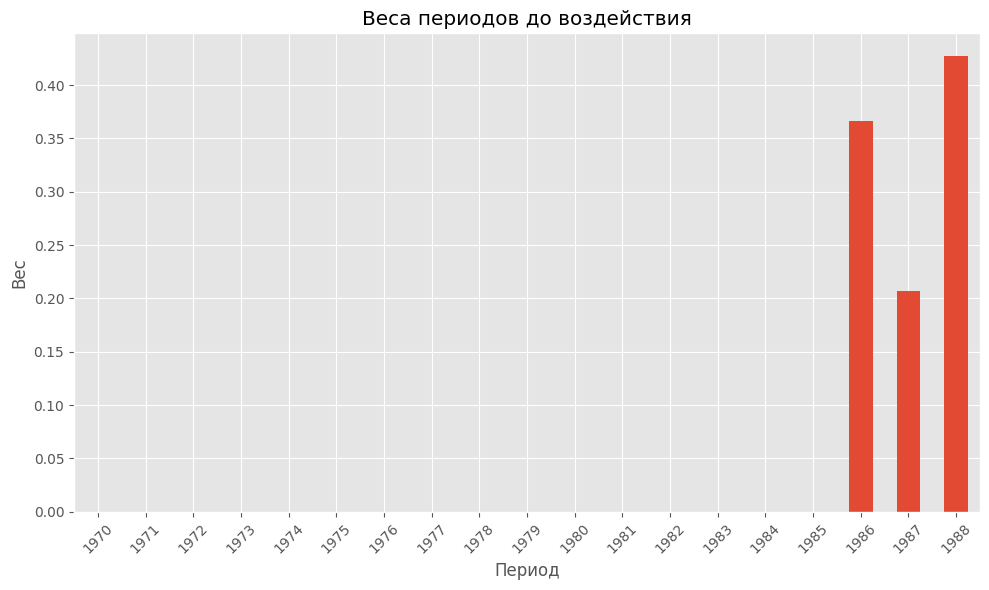

In [14]:
# Визуализация весов времени
time_weights = sdid_model.time_weights_

plt.figure(figsize=(10, 6))
time_weights.plot(kind='bar')
plt.title('Веса периодов до воздействия')
plt.xlabel('Период')
plt.ylabel('Вес')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()